# A4：图卷积网络

## 导入所需的库

## 数据集导入并划分训练/验证/测试集

### 加载数据集

In [1]:
import pickle
import re
import numpy as np
from matplotlib import pyplot as plt
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from collections import defaultdict
from scipy.sparse import csr_matrix
import torch
from torch_geometric.data import Data
import torch.optim as optim
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
import os
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.nn import GATConv
import torch.nn as nn
from sklearn.metrics import precision_score, recall_score, f1_score

D:\Anaconda3\lib\site-packages\torch_geometric\typing.py:63: UserWarning: An issue occurred while importing 'torch-scatter'. Disabling its usage. Stacktrace: [WinError 127] 找不到指定的程序。
  warnings.warn(f"An issue occurred while importing 'torch-scatter'. "
D:\Anaconda3\lib\site-packages\h5py\__init__.py:36: UserWarning: h5py is running against HDF5 1.12.2 when it was built against 1.12.1, this may cause problems
  _warn(("h5py is running against HDF5 {0} when it was built against {1}, "


In [2]:
def clean_text(text):
    text = text.lower()
    text = re.sub(r'\b\w{1,2}\b', '', text)  # 去除短词
    text = re.sub(r'[^a-z\s]', '', text)  # 去除非字母字符
    lemmatizer = WordNetLemmatizer()
    words = text.split()
    words = [lemmatizer.lemmatize(word) for word in words if word not in stopwords.words('english')]
    return ' '.join(words)


# 加载数据集
def load_dataset(file_path):
    with open(file_path, 'r', encoding='latin1') as file:
        data = file.readlines()
    return [clean_text(line.strip().split('\t')[1]) for line in data]


def load_labels(file_path):
    # 读取所有标签
    with open(file_path, 'r', encoding='utf-8') as file:
        labels = [line.strip().split()[1] for line in file]

        # 创建一个从标签名到整数的映射
    unique_labels = sorted(set(labels))
    label_map = {label: i for i, label in enumerate(unique_labels)}

    # 将标签转换为对应的整数
    labels = [label_map[label] for label in labels]
    return labels, label_map


# 加载文档数据
# texts = load_dataset('data/r52.txt')
FILE_NAME = 'r52'  # 可以选择r8或r52 
CLEANED_TEXTS_FILE = f'data/{FILE_NAME}-clean.pkl'  # 定义保存清理过的文本数据的文件名
# 加载或保存清理后的文本数据
if os.path.exists(CLEANED_TEXTS_FILE):
    with open(CLEANED_TEXTS_FILE, 'rb') as f:
        texts = pickle.load(f)
else:
    # 加载文档数据
    texts = load_dataset(f'data/{FILE_NAME}.txt')
    # 进行文本清洗
    texts = [clean_text(text) for text in texts]
    # 保存清理过的文本数据到文件
    with open(CLEANED_TEXTS_FILE, 'wb') as f:
        pickle.dump(texts, f)




### 划分数据集

In [3]:
# 假设 N 是文档的总数
N = len(texts)
# 生成随机索引来划分训练、验证和测试集
indices = torch.randperm(N)
# 计算训练、验证和测试集的大小
train_size = int(0.7 * N)
val_size = int(0.15 * N)
# 创建掩码
train_mask = torch.zeros(N, dtype=torch.bool)
val_mask = torch.zeros(N, dtype=torch.bool)
test_mask = torch.zeros(N, dtype=torch.bool)
# 分配掩码
train_mask[indices[:train_size]] = True
val_mask[indices[train_size:train_size + val_size]] = True
test_mask[indices[train_size + val_size:]] = True

## GCN and GAT 实现

### 图的构建（参数初始化）

In [4]:
# 构建特征矩阵
def build_feature_matrix(texts):
    vectorizer = TfidfVectorizer(max_features=1000)  # 取最重要的1000个特征
    X = vectorizer.fit_transform(texts)
    return X.toarray()


# 构建邻接矩阵
def build_adjacency_matrix2(feature_matrix):
    cosine_sim = cosine_similarity(feature_matrix)
    adjacency_matrix = (cosine_sim > 0.5).astype(int)  # 举例：相似度大于0.5则认为有连接
    np.fill_diagonal(adjacency_matrix, 0)  # 对角线元素设为0，避免自环
    return csr_matrix(adjacency_matrix)  # 使用稀疏矩阵表示


# GCN,GAT构建
# 构建特征矩阵
feature_matrix = build_feature_matrix(texts)
# 构建邻接矩阵
adjacency_matrix = build_adjacency_matrix2(feature_matrix)
# 转换邻接矩阵为 COO 格式的边索引
edge_index = torch.tensor(np.array(adjacency_matrix.nonzero()), dtype=torch.long)
# 加载标签并转换为 Tensor
labels, label_map = load_labels(f'data/{FILE_NAME}-label.txt')
labels = torch.tensor(labels, dtype=torch.long)
# 构建数据对象
data = Data(x=torch.tensor(feature_matrix, dtype=torch.float), edge_index=edge_index, y=labels)
# 将掩码添加到数据对象中
data.train_mask = train_mask
data.val_mask = val_mask
data.test_mask = test_mask
# 初始化模型
num_features = feature_matrix.shape[1]  # 特征维度
num_classes = len(set(labels.numpy()))  # 类别数

### GCN结构

In [5]:
class GCN(torch.nn.Module):
    def __init__(self, num_features, num_classes):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(num_features, 8)
        self.conv2 = GCNConv(8, num_classes)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index

        x = F.relu(self.conv1(x, edge_index))
        x = F.dropout(x, training=self.training)
        x = self.conv2(x, edge_index)

        # print("Output shape:", x.shape)

        return F.log_softmax(x, dim=1)

### GAT结构

In [10]:
class GAT(torch.nn.Module):
    def __init__(self, num_features, num_classes):
        super(GAT, self).__init__()
        self.conv1 = GATConv(num_features, 8, heads=8, dropout=0.6)
        # 如果您想要多层 GAT，可以在这里添加更多层
        self.conv2 = GATConv(8 * 8, num_classes, heads=1, concat=False, dropout=0.6)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index

        x = F.dropout(x, p=0.6, training=self.training)
        x = F.elu(self.conv1(x, edge_index))
        x = F.dropout(x, p=0.6, training=self.training)
        x = self.conv2(x, edge_index)

        return F.log_softmax(x, dim=1)

### 模型加载（GCN或GAT）

In [6]:
# GCN 图卷积网络
model = GCN(num_features=num_features, num_classes=num_classes)

In [11]:
 # GAT 注意力
model = GAT(num_features=num_features, num_classes=num_classes)

### 训练及测试

In [12]:
# 训练
def train():
    model.train()
    optimizer.zero_grad()
    out = model(data)
    loss = F.nll_loss(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()
    return loss


# 测试
def test():
    model.eval()
    logits, accs = model(data), []
    all_preds, all_labels = [], []

    for _, mask in data('train_mask', 'val_mask', 'test_mask'):
        pred = logits[mask].max(1)[1]

        all_preds.extend(pred.tolist())
        all_labels.extend(data.y[mask].tolist())

        acc = pred.eq(data.y[mask]).sum().item() / mask.sum().item()
        accs.append(acc)

    precision = precision_score(all_labels, all_preds, average='macro', zero_division=0)
    recall = recall_score(all_labels, all_preds, average='macro', zero_division=0)
    f1 = f1_score(all_labels, all_preds, average='macro', zero_division=0)

    return accs, precision, recall, f1


# 用于保存损失和准确率的列表
train_losses = []
train_accuracies = []
val_accuracies = []
test_accuracies = []
# 优化器
optimizer = optim.Adam(model.parameters(), lr=0.1)

# GCN和GAT的训练和测试循环
for epoch in range(200):
    loss = train()
    torch.cuda.empty_cache()  # 清理 GPU 缓存
    (train_acc, val_acc, test_acc), precision, recall, f1 = test()

    # 保存数据
    train_losses.append(loss.item())
    train_accuracies.append(train_acc)
    val_accuracies.append(val_acc)
    test_accuracies.append(test_acc)

    print(
        f'Epoch: {epoch + 1:03d}, Loss: {loss:.4f}, Train: {train_acc:.4f}, Val: {val_acc:.4f}, Test: {test_acc:.4f}')
    print(f'Epoch: {epoch + 1:03d}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1:.4f}')

Epoch: 001, Loss: 3.9452, Train: 0.7110, Val: 0.6960, Test: 0.7062
Epoch: 002, Loss: 2.3426, Train: 0.7320, Val: 0.7201, Test: 0.7326
Epoch: 003, Loss: 2.2869, Train: 0.7788, Val: 0.7670, Test: 0.7736
Epoch: 004, Loss: 1.6315, Train: 0.8218, Val: 0.8168, Test: 0.8125
Epoch: 005, Loss: 1.5502, Train: 0.8625, Val: 0.8513, Test: 0.8513
Epoch: 006, Loss: 1.5056, Train: 0.8874, Val: 0.8747, Test: 0.8725
Epoch: 007, Loss: 1.3600, Train: 0.8868, Val: 0.8667, Test: 0.8667
Epoch: 008, Loss: 1.2320, Train: 0.8848, Val: 0.8667, Test: 0.8725
Epoch: 009, Loss: 1.2654, Train: 0.8903, Val: 0.8711, Test: 0.8799
Epoch: 010, Loss: 1.1843, Train: 0.8989, Val: 0.8791, Test: 0.8791
Epoch: 011, Loss: 1.1507, Train: 0.9050, Val: 0.8842, Test: 0.8806
Epoch: 012, Loss: 1.1131, Train: 0.9082, Val: 0.8879, Test: 0.8894
Epoch: 013, Loss: 1.1271, Train: 0.9129, Val: 0.8923, Test: 0.8916
Epoch: 014, Loss: 1.1164, Train: 0.9075, Val: 0.8894, Test: 0.8821
Epoch: 015, Loss: 1.0514, Train: 0.9082, Val: 0.8916, Test: 0.

### 作图及保存模型

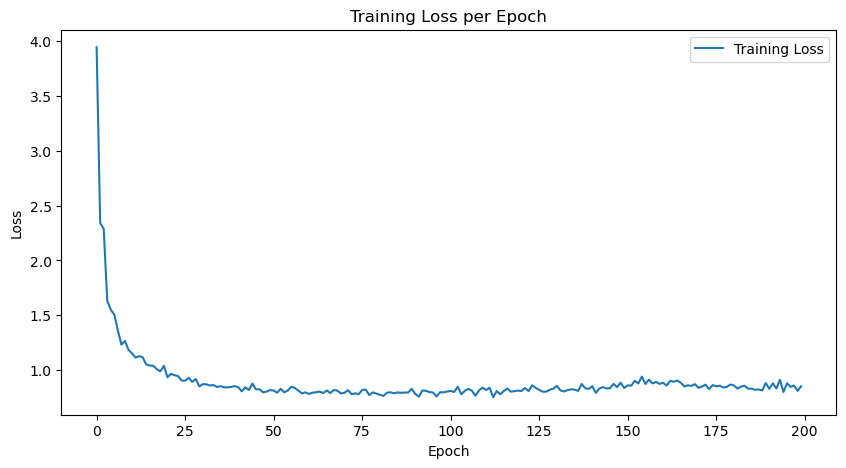

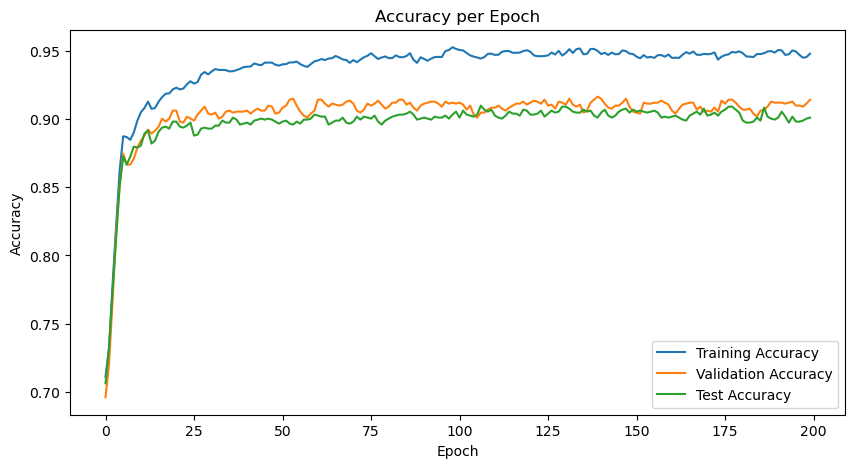

In [13]:
def plot_training_results(train_losses, train_accuracies, val_accuracies, test_accuracies):
    # 绘制损失图
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label='Training Loss')
    plt.title("Training Loss per Epoch")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

    # 绘制准确率图
    plt.figure(figsize=(10, 5))
    plt.plot(train_accuracies, label='Training Accuracy')
    plt.plot(val_accuracies, label='Validation Accuracy')
    plt.plot(test_accuracies, label='Test Accuracy')
    plt.title("Accuracy per Epoch")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.show()


plot_training_results(train_losses, train_accuracies, val_accuracies, test_accuracies)
torch.save(model, 'model/model_GAT.pth')

## CNN and LSTM 实现

## 参数初始化

In [ ]:
def tokenize_and_pad_texts(texts, max_len=500):
    # 创建并训练分词器
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(texts)

    # 将文本转换为整数序列
    sequences = tokenizer.texts_to_sequences(texts)

    # 填充序列以获得统一的长度
    padded_sequences = pad_sequences(sequences, maxlen=max_len, padding='post')

    return padded_sequences, tokenizer.word_index


# 设定最大序列长度
MAX_SEQUENCE_LENGTH = 50
# 获取整数序列和词汇表
texts_int_seq, word_index = tokenize_and_pad_texts(texts, MAX_SEQUENCE_LENGTH)
VOCAB_SIZE = len(word_index) + 1  # 加1因为索引0通常是填充符号
EMBEDDING_DIM = 100  # 可以根据需要调整
FILTER_SIZES = [3, 4, 5]  # 卷积核的大小
NUM_FILTERS = 100  # 每种大小的卷积核的数量
NUM_CLASSES = len(set(labels))  # 类别数
# 获取整数序列和词汇表
texts_tensor = torch.tensor(texts_int_seq, dtype=torch.long)  # 转换为 Tensor
# 加载标签
labels_tensor = torch.tensor(labels, dtype=torch.long)

### CNN结构

In [ ]:
class TextCNN(nn.Module):
    def __init__(self, vocab_size, embedding_dim, num_classes, filter_sizes, num_filters):
        super(TextCNN, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.convs = nn.ModuleList(
            [nn.Conv2d(1, num_filters, (k, embedding_dim)) for k in filter_sizes]
        )
        self.dropout = nn.Dropout(0.5)
        self.fc = nn.Linear(len(filter_sizes) * num_filters, num_classes)

    def forward(self, x):
        x = self.embedding(x)  # [N, L, D]
        x = x.unsqueeze(1)  # [N, 1, L, D]
        x = [F.relu(conv(x)).squeeze(3) for conv in self.convs]  # [(N, Co, L), ...] * len(Ks)
        x = [F.max_pool1d(i, i.size(2)).squeeze(2) for i in x]  # [(N, Co), ...] * len(Ks)
        x = torch.cat(x, 1)
        x = self.dropout(x)
        logit = self.fc(x)
        return logit

### LSTM结构

In [ ]:
class TextLSTM(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, num_classes):
        super(TextLSTM, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, num_layers=1, batch_first=True)
        self.fc = nn.Linear(hidden_dim, num_classes)

    def forward(self, x):
        x = self.embedding(x)  # [N, L, D]
        x, (h_n, c_n) = self.lstm(x)  # h_n is the hidden state
        x = h_n[-1, :, :]  # Take the last layer hidden state
        x = self.fc(x)
        return F.log_softmax(x, dim=1)

### 模型加载

In [ ]:
# CNN模型加载
model = TextCNN(VOCAB_SIZE, EMBEDDING_DIM, NUM_CLASSES, FILTER_SIZES, NUM_FILTERS)

In [ ]:
# LSTM模型加载
HIDDEN_DIM = 128  # 隐藏层维度，可以调整
model = TextLSTM(VOCAB_SIZE, EMBEDDING_DIM, HIDDEN_DIM, NUM_CLASSES)

### 训练和测试

In [ ]:
def train_cnn():
    model.train()
    optimizer.zero_grad()
    out = model(texts_tensor)  # 使用处理过的文本序列
    loss = F.cross_entropy(out[train_mask], labels_tensor[train_mask])
    loss.backward()
    optimizer.step()
    return loss


def test_cnn():
    model.eval()
    logits = model(texts_tensor)  # 使用处理过的文本序列
    accs = []
    for mask in [train_mask, val_mask, test_mask]:
        pred = logits[mask].max(1)[1]
        acc = pred.eq(labels_tensor[mask]).sum().item() / mask.sum().item()
        accs.append(acc)
    return accs


# 优化器
optimizer = optim.Adam(model.parameters(), lr=0.001)

for epoch in range(200):
    loss = train_cnn()
    torch.cuda.empty_cache()  # 清理 GPU 缓存
    train_acc, val_acc, test_acc = test_cnn()

    # 保存数据
    train_losses.append(loss.item())
    train_accuracies.append(train_acc)
    val_accuracies.append(val_acc)
    test_accuracies.append(test_acc)
    print(
        f'Epoch: {epoch + 1:03d}, Loss: {loss:.4f}, Train: {train_acc:.4f}, Val: {val_acc:.4f}, Test: {test_acc:.4f}')


### 作图及保存模型

In [ ]:
def plot_training_results(train_losses, train_accuracies, val_accuracies, test_accuracies):
    # 绘制损失图
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label='Training Loss')
    plt.title("Training Loss per Epoch")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

    # 绘制准确率图
    plt.figure(figsize=(10, 5))
    plt.plot(train_accuracies, label='Training Accuracy')
    plt.plot(val_accuracies, label='Validation Accuracy')
    plt.plot(test_accuracies, label='Test Accuracy')
    plt.title("Accuracy per Epoch")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.show()


plot_training_results(train_losses, train_accuracies, val_accuracies, test_accuracies)
torch.save(model, 'model/model_CNN.pth')